In [ ]:
#调度器选择
# 模型定义
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# CIFAR-10的类别
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 定义VGG网络配置
cfg = {
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
}

# 定义VGG网络类
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        self._initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




/home/ma-user/anaconda3/envs/PyTorch-1.8.2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda:0


In [2]:
# 学习率调度器对比实验

# 数据预处理
transform_train = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为Tensor，同时将像素值从[0, 255]范围缩放到[0.0, 1.0]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载CIFAR-10数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)


model_name = 'VGG13'
base_lr = 0.01  # 使用基础学习率

# 定义要测试的学习率调度器
schedulers_to_test = {
    'StepLR': optim.lr_scheduler.StepLR,  # 阶梯式衰减
    'MultiStepLR': optim.lr_scheduler.MultiStepLR,  # 多阶段衰减
    'CosineAnnealingLR': optim.lr_scheduler.CosineAnnealingLR,  # 余弦退火
    'ReduceLROnPlateau': optim.lr_scheduler.ReduceLROnPlateau,  # 根据验证集表现衰减
}

# 实验参数
epoch_count = 30  # 训练轮数
results = {}

def train_model_with_scheduler(model, scheduler_name, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=5e-4)
    
    # 根据调度器名称创建对应调度器
    if scheduler_name == 'None':
        scheduler = None
    elif scheduler_name == 'StepLR':
        scheduler = schedulers_to_test[scheduler_name](optimizer, step_size=10, gamma=0.1)
    elif scheduler_name == 'MultiStepLR':
        scheduler = schedulers_to_test[scheduler_name](optimizer, milestones=[10, 20], gamma=0.1)
    elif scheduler_name == 'CosineAnnealingLR':
        scheduler = schedulers_to_test[scheduler_name](optimizer, T_max=epochs)
    elif scheduler_name == 'ReduceLROnPlateau':
        scheduler = schedulers_to_test[scheduler_name](optimizer, mode='max', factor=0.1, patience=5)
    
    model = model.to(device)
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    times = []
    lrs = []  # 记录每个epoch的学习率
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        
        print(f'\n第 {epoch} 轮 - {scheduler_name} (当前lr={current_lr:.6f})')
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), 
                    desc=f'Training:Epoch [{epoch}/{epochs}]')
        
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # 计算训练结果
        train_epoch_loss = train_loss / len(trainloader)
        train_epoch_acc = 100. * correct / total
        train_losses.append(train_epoch_loss)
        train_accs.append(train_epoch_acc)
        
        # 测试
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(testloader), 
                                                  total=len(testloader), 
                                                  desc=f'Testing:'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # 计算测试结果
        test_epoch_loss = test_loss / len(testloader)
        test_epoch_acc = 100. * correct / total
        test_losses.append(test_epoch_loss)
        test_accs.append(test_epoch_acc)
        
        epoch_time = time.time() - start_time
        times.append(epoch_time)
        
        print(f'测试 | 损失: {test_epoch_loss:.3f} | 准确率: {test_epoch_acc:.3f}% | 用时: {epoch_time:.1f}秒')
        
        # 更新学习率调度器
        if scheduler is not None:
            if scheduler_name == 'ReduceLROnPlateau':
                scheduler.step(test_epoch_acc)  # 根据验证准确率调整
            else:
                scheduler.step()
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'times': times,
        'lrs': lrs,
        'final_accuracy': test_accs[-1],
        'total_time': sum(times)
    }

# 主实验循环
print("开始 VGG-13 学习率调度器对比实验...")

# 遍历不同调度器
for scheduler_name in schedulers_to_test.keys():
    model = VGG(model_name)  # 创建新的VGG-13模型实例
    print(f"\n开始训练 VGG-13 使用 SGD 优化器，学习率调度器 = {scheduler_name}")
    
    # 训练模型并记录结果
    results[scheduler_name] = train_model_with_scheduler(model, scheduler_name, epochs=epoch_count)
    
    # 保存模型
    torch.save(model.state_dict(), f'cifar10_vgg13_sgd_{scheduler_name.lower()}.pth')
    print(f"模型已保存为 cifar10_vgg13_sgd_{scheduler_name.lower()}.pth")

Files already downloaded and verified
Files already downloaded and verified
开始 VGG-13 学习率调度器对比实验...

开始训练 VGG-13 使用 SGD 优化器，学习率调度器 = StepLR

第 1 轮 - StepLR (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.36it/s]

测试 | 损失: 2.298 | 准确率: 10.880% | 用时: 24.0秒

第 2 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.00it/s]

测试 | 损失: 2.011 | 准确率: 19.000% | 用时: 24.1秒

第 3 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.06it/s]

测试 | 损失: 1.808 | 准确率: 23.360% | 用时: 24.3秒

第 4 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.03it/s]

测试 | 损失: 1.666 | 准确率: 29.320% | 用时: 24.2秒

第 5 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.53it/s]


测试 | 损失: 1.559 | 准确率: 36.880% | 用时: 24.5秒

第 6 轮 - StepLR (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 50.75it/s]

测试 | 损失: 1.480 | 准确率: 44.980% | 用时: 24.4秒

第 7 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 48.49it/s]

测试 | 损失: 1.338 | 准确率: 49.600% | 用时: 24.4秒

第 8 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.64it/s]

测试 | 损失: 1.113 | 准确率: 59.210% | 用时: 24.0秒

第 9 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.40it/s]

测试 | 损失: 1.094 | 准确率: 61.210% | 用时: 24.0秒

第 10 轮 - StepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.93it/s]

测试 | 损失: 1.034 | 准确率: 63.740% | 用时: 24.1秒

第 11 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.68it/s]

测试 | 损失: 0.893 | 准确率: 69.260% | 用时: 24.1秒

第 12 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.19it/s]

测试 | 损失: 0.915 | 准确率: 69.800% | 用时: 24.0秒

第 13 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.48it/s]

测试 | 损失: 0.941 | 准确率: 69.920% | 用时: 24.2秒

第 14 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.34it/s]

测试 | 损失: 0.968 | 准确率: 70.410% | 用时: 24.2秒

第 15 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.40it/s]

测试 | 损失: 1.004 | 准确率: 70.170% | 用时: 24.2秒

第 16 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.50it/s]

测试 | 损失: 1.035 | 准确率: 70.310% | 用时: 24.1秒

第 17 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.43it/s]

测试 | 损失: 1.066 | 准确率: 70.440% | 用时: 24.2秒

第 18 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.34it/s]

测试 | 损失: 1.099 | 准确率: 70.380% | 用时: 24.1秒

第 19 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.34it/s]

测试 | 损失: 1.161 | 准确率: 69.710% | 用时: 24.2秒

第 20 轮 - StepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.71it/s]

测试 | 损失: 1.212 | 准确率: 69.680% | 用时: 24.3秒

第 21 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.38it/s]

测试 | 损失: 1.202 | 准确率: 70.470% | 用时: 24.3秒

第 22 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.57it/s]

测试 | 损失: 1.213 | 准确率: 70.410% | 用时: 24.2秒

第 23 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.44it/s]

测试 | 损失: 1.206 | 准确率: 70.520% | 用时: 24.1秒

第 24 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.04it/s]

测试 | 损失: 1.226 | 准确率: 70.310% | 用时: 24.2秒

第 25 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.15it/s]

测试 | 损失: 1.231 | 准确率: 70.240% | 用时: 24.1秒

第 26 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.59it/s]

测试 | 损失: 1.235 | 准确率: 70.350% | 用时: 24.3秒

第 27 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.42it/s]

测试 | 损失: 1.249 | 准确率: 70.370% | 用时: 24.3秒

第 28 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.17it/s]

测试 | 损失: 1.253 | 准确率: 70.290% | 用时: 24.4秒

第 29 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.16it/s]

测试 | 损失: 1.265 | 准确率: 70.350% | 用时: 24.3秒

第 30 轮 - StepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.51it/s]


测试 | 损失: 1.269 | 准确率: 70.190% | 用时: 24.3秒
模型已保存为 cifar10_vgg13_sgd_steplr.pth

开始训练 VGG-13 使用 SGD 优化器，学习率调度器 = MultiStepLR

第 1 轮 - MultiStepLR (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.06it/s]


测试 | 损失: 2.298 | 准确率: 10.000% | 用时: 24.2秒

第 2 轮 - MultiStepLR (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.55it/s]

测试 | 损失: 2.035 | 准确率: 18.770% | 用时: 24.1秒

第 3 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.25it/s]

测试 | 损失: 1.806 | 准确率: 21.350% | 用时: 24.2秒

第 4 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.73it/s]

测试 | 损失: 1.715 | 准确率: 28.480% | 用时: 24.3秒

第 5 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.43it/s]

测试 | 损失: 1.539 | 准确率: 41.150% | 用时: 24.4秒

第 6 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.85it/s]

测试 | 损失: 1.395 | 准确率: 47.670% | 用时: 24.2秒

第 7 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.49it/s]

测试 | 损失: 1.212 | 准确率: 54.590% | 用时: 24.4秒

第 8 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.12it/s]

测试 | 损失: 1.152 | 准确率: 56.970% | 用时: 24.3秒

第 9 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.64it/s]

测试 | 损失: 1.161 | 准确率: 61.300% | 用时: 24.4秒

第 10 轮 - MultiStepLR (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.16it/s]

测试 | 损失: 1.114 | 准确率: 62.870% | 用时: 24.4秒

第 11 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.93it/s]

测试 | 损失: 0.907 | 准确率: 70.280% | 用时: 24.3秒

第 12 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.45it/s]

测试 | 损失: 0.928 | 准确率: 70.130% | 用时: 24.3秒

第 13 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.71it/s]

测试 | 损失: 0.992 | 准确率: 69.900% | 用时: 24.3秒

第 14 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.39it/s]

测试 | 损失: 1.004 | 准确率: 70.430% | 用时: 24.4秒

第 15 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.06it/s]

测试 | 损失: 1.036 | 准确率: 69.870% | 用时: 24.4秒

第 16 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.50it/s]

测试 | 损失: 1.086 | 准确率: 69.900% | 用时: 24.5秒

第 17 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.70it/s]

测试 | 损失: 1.159 | 准确率: 69.700% | 用时: 24.3秒

第 18 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.28it/s]

测试 | 损失: 1.202 | 准确率: 69.370% | 用时: 24.4秒

第 19 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.12it/s]

测试 | 损失: 1.242 | 准确率: 69.650% | 用时: 24.3秒

第 20 轮 - MultiStepLR (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.72it/s]

测试 | 损失: 1.277 | 准确率: 69.840% | 用时: 24.3秒

第 21 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.06it/s]

测试 | 损失: 1.274 | 准确率: 70.240% | 用时: 24.5秒

第 22 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.58it/s]


测试 | 损失: 1.288 | 准确率: 70.050% | 用时: 24.3秒

第 23 轮 - MultiStepLR (当前lr=0.000100)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.50it/s]

测试 | 损失: 1.297 | 准确率: 70.200% | 用时: 24.3秒

第 24 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.95it/s]

测试 | 损失: 1.306 | 准确率: 70.160% | 用时: 24.3秒

第 25 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.03it/s]

测试 | 损失: 1.319 | 准确率: 70.110% | 用时: 24.2秒

第 26 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.28it/s]

测试 | 损失: 1.327 | 准确率: 70.060% | 用时: 24.3秒

第 27 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.80it/s]

测试 | 损失: 1.339 | 准确率: 70.130% | 用时: 24.2秒

第 28 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.05it/s]

测试 | 损失: 1.350 | 准确率: 70.040% | 用时: 24.4秒

第 29 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.66it/s]

测试 | 损失: 1.355 | 准确率: 70.070% | 用时: 24.4秒

第 30 轮 - MultiStepLR (当前lr=0.000100)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.34it/s]


测试 | 损失: 1.363 | 准确率: 70.080% | 用时: 24.3秒
模型已保存为 cifar10_vgg13_sgd_multisteplr.pth

开始训练 VGG-13 使用 SGD 优化器，学习率调度器 = CosineAnnealingLR

第 1 轮 - CosineAnnealingLR (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.44it/s]

测试 | 损失: 2.301 | 准确率: 12.920% | 用时: 24.2秒

第 2 轮 - CosineAnnealingLR (当前lr=0.009973)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.51it/s]

测试 | 损失: 2.219 | 准确率: 17.190% | 用时: 24.3秒

第 3 轮 - CosineAnnealingLR (当前lr=0.009891)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.36it/s]

测试 | 损失: 1.832 | 准确率: 22.300% | 用时: 24.4秒

第 4 轮 - CosineAnnealingLR (当前lr=0.009755)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.63it/s]

测试 | 损失: 1.709 | 准确率: 28.370% | 用时: 24.4秒

第 5 轮 - CosineAnnealingLR (当前lr=0.009568)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.44it/s]

测试 | 损失: 1.618 | 准确率: 32.350% | 用时: 24.4秒

第 6 轮 - CosineAnnealingLR (当前lr=0.009330)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.61it/s]

测试 | 损失: 1.430 | 准确率: 43.050% | 用时: 24.2秒

第 7 轮 - CosineAnnealingLR (当前lr=0.009045)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.87it/s]

测试 | 损失: 1.272 | 准确率: 51.850% | 用时: 24.4秒

第 8 轮 - CosineAnnealingLR (当前lr=0.008716)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.48it/s]

测试 | 损失: 1.420 | 准确率: 47.680% | 用时: 24.2秒

第 9 轮 - CosineAnnealingLR (当前lr=0.008346)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.49it/s]

测试 | 损失: 1.204 | 准确率: 57.970% | 用时: 24.4秒

第 10 轮 - CosineAnnealingLR (当前lr=0.007939)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.86it/s]

测试 | 损失: 1.179 | 准确率: 59.570% | 用时: 24.6秒

第 11 轮 - CosineAnnealingLR (当前lr=0.007500)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.53it/s]

测试 | 损失: 1.301 | 准确率: 58.460% | 用时: 24.2秒

第 12 轮 - CosineAnnealingLR (当前lr=0.007034)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.79it/s]

测试 | 损失: 1.141 | 准确率: 65.190% | 用时: 24.4秒

第 13 轮 - CosineAnnealingLR (当前lr=0.006545)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.57it/s]

测试 | 损失: 1.008 | 准确率: 68.000% | 用时: 24.3秒

第 14 轮 - CosineAnnealingLR (当前lr=0.006040)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.76it/s]

测试 | 损失: 1.178 | 准确率: 65.720% | 用时: 24.5秒

第 15 轮 - CosineAnnealingLR (当前lr=0.005523)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.45it/s]

测试 | 损失: 1.130 | 准确率: 68.460% | 用时: 24.3秒

第 16 轮 - CosineAnnealingLR (当前lr=0.005000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.24it/s]

测试 | 损失: 1.150 | 准确率: 69.820% | 用时: 24.5秒

第 17 轮 - CosineAnnealingLR (当前lr=0.004477)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.03it/s]

测试 | 损失: 1.322 | 准确率: 69.200% | 用时: 24.4秒

第 18 轮 - CosineAnnealingLR (当前lr=0.003960)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.59it/s]

测试 | 损失: 1.569 | 准确率: 67.610% | 用时: 24.5秒

第 19 轮 - CosineAnnealingLR (当前lr=0.003455)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.17it/s]

测试 | 损失: 1.411 | 准确率: 69.580% | 用时: 24.5秒

第 20 轮 - CosineAnnealingLR (当前lr=0.002966)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.04it/s]

测试 | 损失: 1.454 | 准确率: 71.040% | 用时: 24.7秒

第 21 轮 - CosineAnnealingLR (当前lr=0.002500)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.41it/s]

测试 | 损失: 1.560 | 准确率: 71.230% | 用时: 24.5秒

第 22 轮 - CosineAnnealingLR (当前lr=0.002061)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.85it/s]

测试 | 损失: 1.562 | 准确率: 72.400% | 用时: 24.5秒

第 23 轮 - CosineAnnealingLR (当前lr=0.001654)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.69it/s]

测试 | 损失: 1.690 | 准确率: 72.020% | 用时: 24.7秒

第 24 轮 - CosineAnnealingLR (当前lr=0.001284)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.51it/s]

测试 | 损失: 1.735 | 准确率: 72.410% | 用时: 24.5秒

第 25 轮 - CosineAnnealingLR (当前lr=0.000955)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.98it/s]

测试 | 损失: 1.757 | 准确率: 72.510% | 用时: 24.5秒

第 26 轮 - CosineAnnealingLR (当前lr=0.000670)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.66it/s]

测试 | 损失: 1.770 | 准确率: 72.680% | 用时: 24.7秒

第 27 轮 - CosineAnnealingLR (当前lr=0.000432)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.88it/s]


测试 | 损失: 1.801 | 准确率: 72.560% | 用时: 24.7秒

第 28 轮 - CosineAnnealingLR (当前lr=0.000245)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.59it/s]

测试 | 损失: 1.797 | 准确率: 72.690% | 用时: 24.7秒

第 29 轮 - CosineAnnealingLR (当前lr=0.000109)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.00it/s]

测试 | 损失: 1.808 | 准确率: 72.550% | 用时: 24.5秒

第 30 轮 - CosineAnnealingLR (当前lr=0.000027)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.56it/s]


测试 | 损失: 1.819 | 准确率: 72.770% | 用时: 24.7秒
模型已保存为 cifar10_vgg13_sgd_cosineannealinglr.pth

开始训练 VGG-13 使用 SGD 优化器，学习率调度器 = ReduceLROnPlateau

第 1 轮 - ReduceLROnPlateau (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.19it/s]

测试 | 损失: 2.299 | 准确率: 10.030% | 用时: 24.6秒

第 2 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.41it/s]

测试 | 损失: 2.045 | 准确率: 19.600% | 用时: 24.5秒

第 3 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.85it/s]

测试 | 损失: 1.892 | 准确率: 20.520% | 用时: 24.6秒

第 4 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.34it/s]

测试 | 损失: 1.708 | 准确率: 28.430% | 用时: 24.6秒

第 5 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.84it/s]

测试 | 损失: 1.555 | 准确率: 35.950% | 用时: 24.6秒

第 6 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.26it/s]

测试 | 损失: 1.479 | 准确率: 41.870% | 用时: 24.6秒

第 7 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.73it/s]

测试 | 损失: 1.355 | 准确率: 50.280% | 用时: 24.6秒

第 8 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.14it/s]

测试 | 损失: 1.272 | 准确率: 54.910% | 用时: 24.7秒

第 9 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.30it/s]

测试 | 损失: 1.096 | 准确率: 59.980% | 用时: 24.6秒

第 10 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.68it/s]

测试 | 损失: 1.185 | 准确率: 59.230% | 用时: 24.7秒

第 11 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.05it/s]

测试 | 损失: 0.948 | 准确率: 68.080% | 用时: 24.7秒

第 12 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.97it/s]

测试 | 损失: 0.955 | 准确率: 68.940% | 用时: 24.7秒

第 13 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.14it/s]

测试 | 损失: 1.028 | 准确率: 69.050% | 用时: 24.5秒

第 14 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.20it/s]

测试 | 损失: 1.004 | 准确率: 67.940% | 用时: 24.7秒

第 15 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.86it/s]

测试 | 损失: 0.971 | 准确率: 70.900% | 用时: 24.6秒

第 16 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.31it/s]

测试 | 损失: 1.111 | 准确率: 70.780% | 用时: 24.7秒

第 17 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.35it/s]

测试 | 损失: 1.140 | 准确率: 71.930% | 用时: 24.7秒

第 18 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.12it/s]

测试 | 损失: 1.109 | 准确率: 72.230% | 用时: 24.7秒

第 19 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.28it/s]

测试 | 损失: 0.992 | 准确率: 74.970% | 用时: 24.7秒

第 20 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.95it/s]

测试 | 损失: 1.296 | 准确率: 72.000% | 用时: 24.5秒

第 21 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.74it/s]

测试 | 损失: 1.109 | 准确率: 72.960% | 用时: 24.7秒

第 22 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.01it/s]

测试 | 损失: 1.392 | 准确率: 72.520% | 用时: 24.7秒

第 23 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.41it/s]

测试 | 损失: 1.315 | 准确率: 72.820% | 用时: 24.6秒

第 24 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.75it/s]

测试 | 损失: 1.304 | 准确率: 73.880% | 用时: 24.7秒

第 25 轮 - ReduceLROnPlateau (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.34it/s]

测试 | 损失: 1.346 | 准确率: 74.280% | 用时: 24.7秒

第 26 轮 - ReduceLROnPlateau (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 51.73it/s]

测试 | 损失: 1.090 | 准确率: 78.370% | 用时: 24.7秒

第 27 轮 - ReduceLROnPlateau (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.46it/s]

测试 | 损失: 1.133 | 准确率: 78.510% | 用时: 24.5秒

第 28 轮 - ReduceLROnPlateau (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.22it/s]

测试 | 损失: 1.183 | 准确率: 78.570% | 用时: 24.6秒

第 29 轮 - ReduceLROnPlateau (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.47it/s]

测试 | 损失: 1.211 | 准确率: 78.840% | 用时: 24.5秒

第 30 轮 - ReduceLROnPlateau (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.75it/s]

测试 | 损失: 1.245 | 准确率: 79.010% | 用时: 24.5秒
模型已保存为 cifar10_vgg13_sgd_reducelronplateau.pth


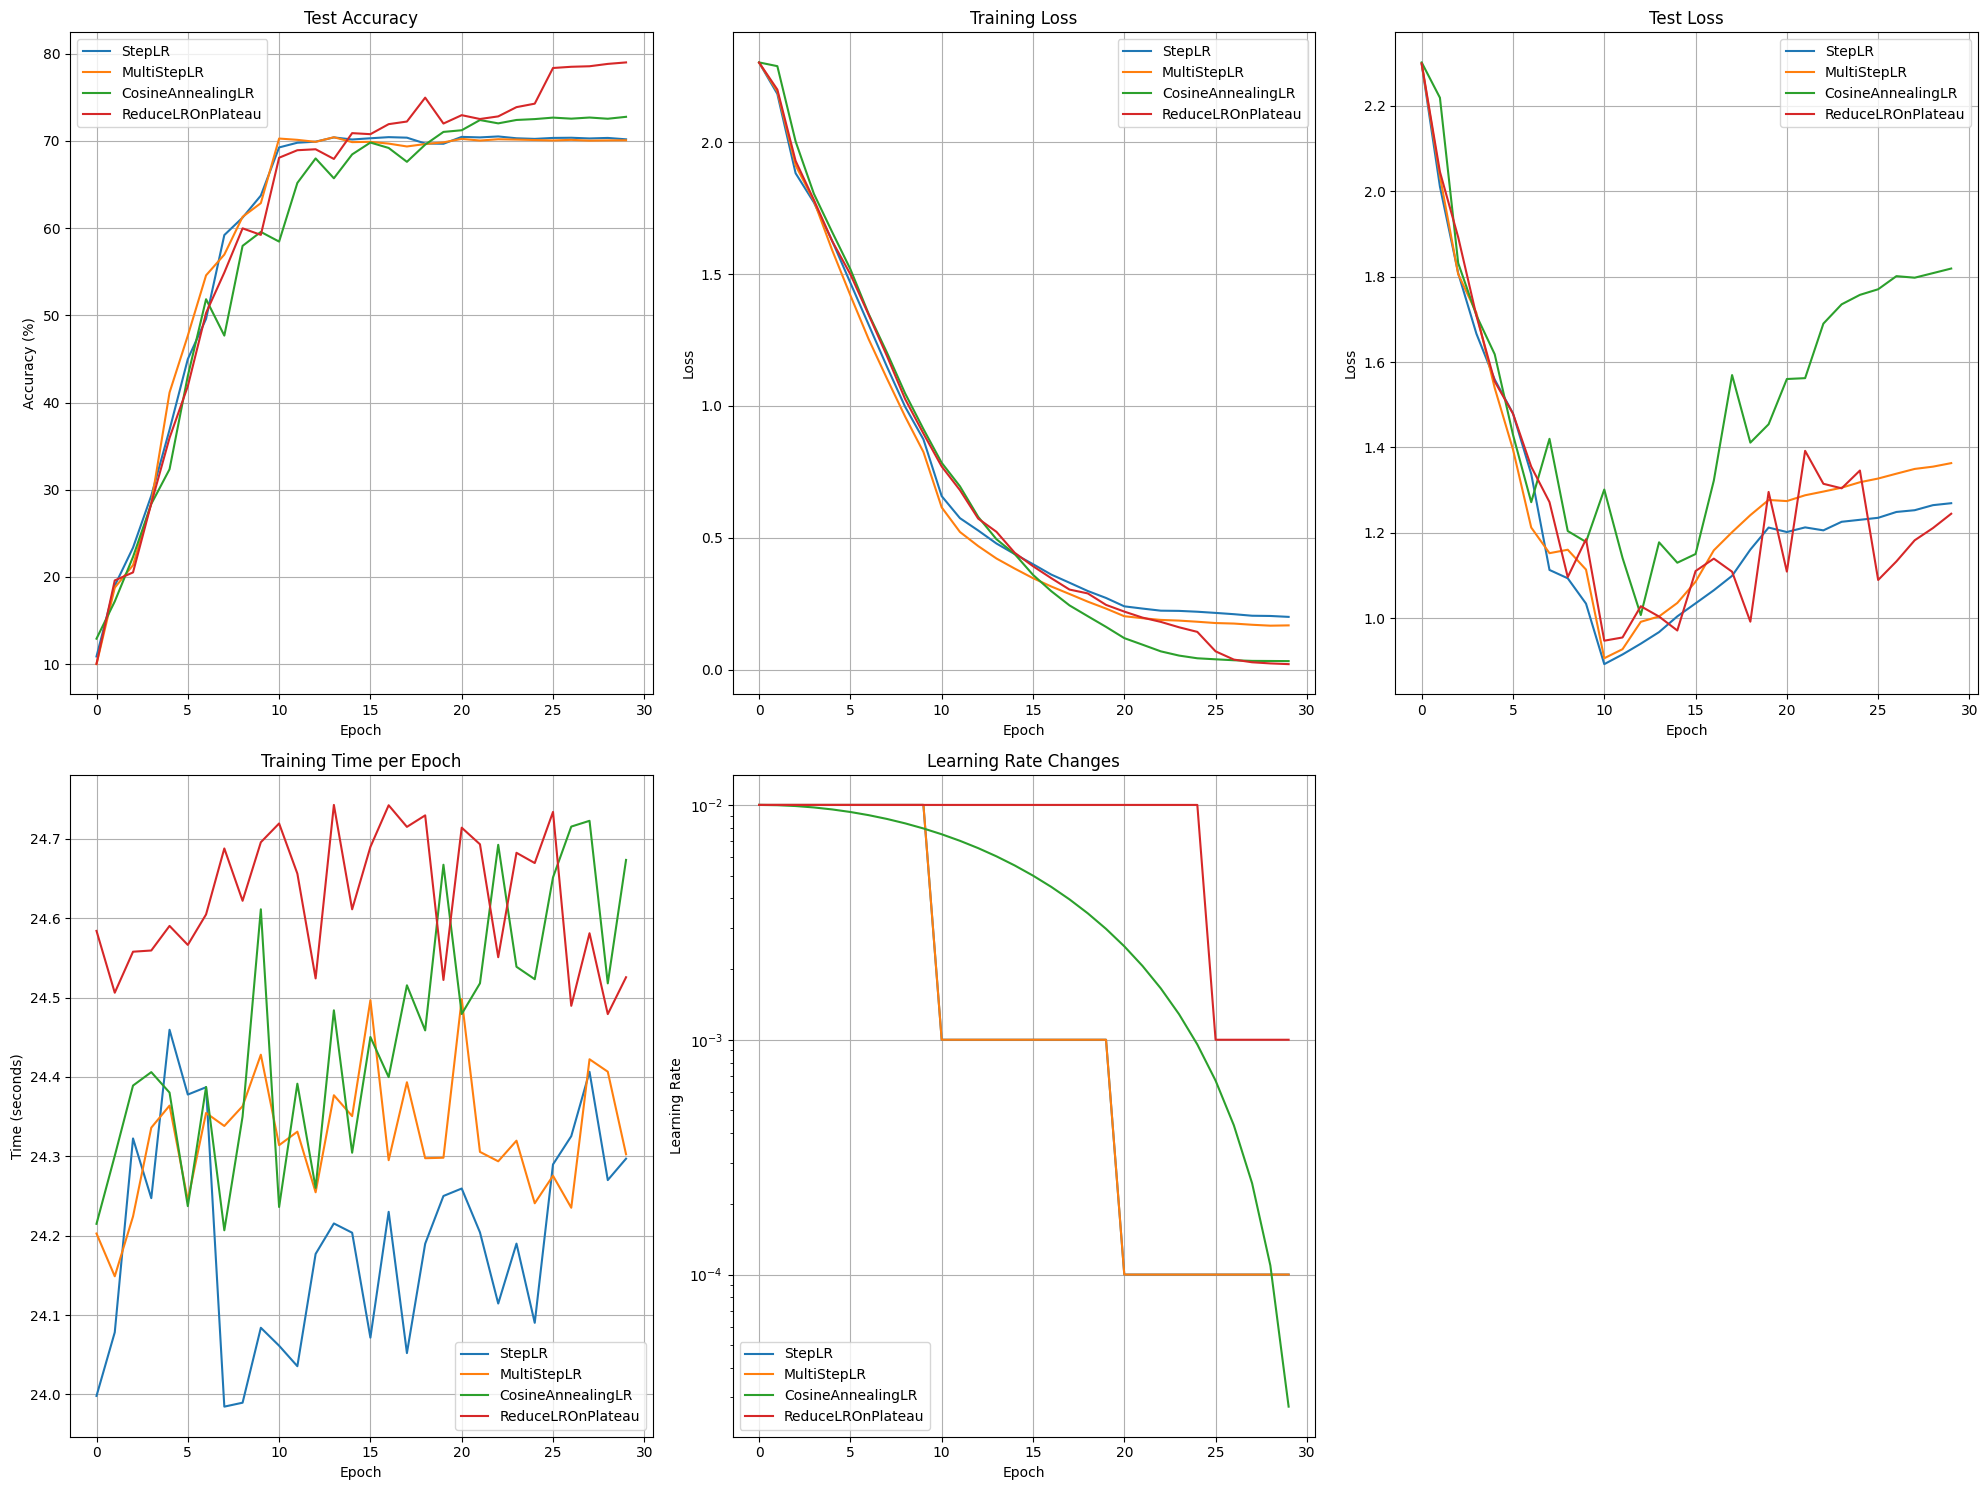


实验结果总结:
--------------------------------------------------------------------------------
学习率调度器                    最终准确率           总训练时间           每轮平均时间         
--------------------------------------------------------------------------------
StepLR                    70.19          % 725.86         秒 24.20          秒
MultiStepLR               70.08          % 729.71         秒 24.32          秒
CosineAnnealingLR         72.77          % 733.69         秒 24.46          秒
ReduceLROnPlateau         79.01          % 738.75         秒 24.62          秒
--------------------------------------------------------------------------------


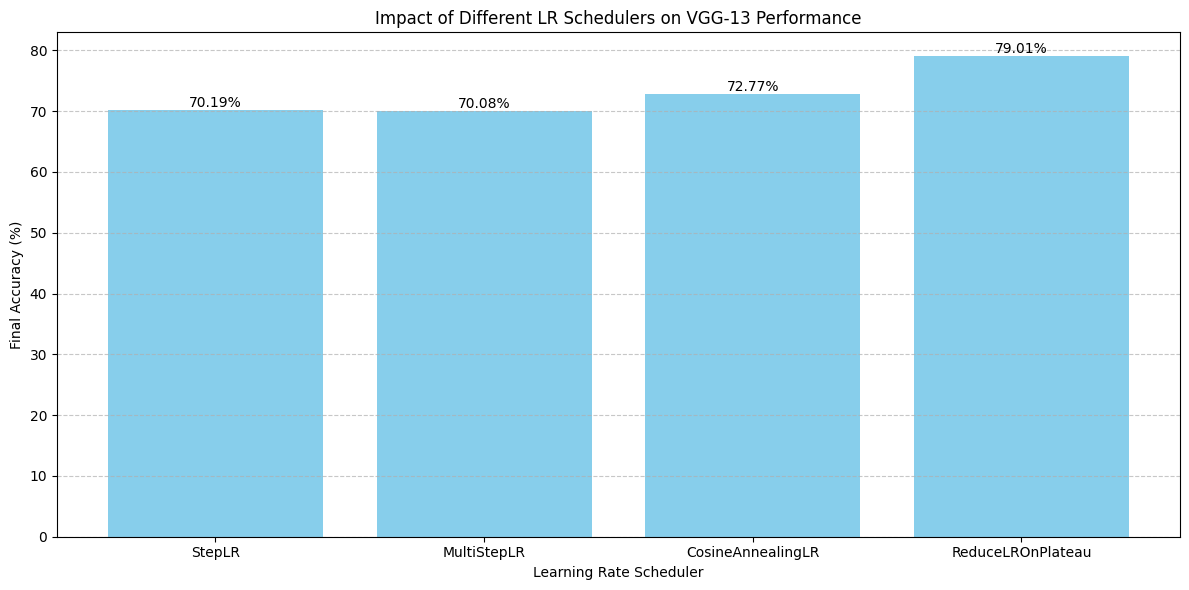

In [3]:
# 可视化不同学习率调度器的性能比较
plt.figure(figsize=(20, 15))

# 显示测试准确率
plt.subplot(2, 3, 1)
for scheduler_name in results:
    plt.plot(results[scheduler_name]['test_accs'], label=scheduler_name)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 显示训练损失
plt.subplot(2, 3, 2)
for scheduler_name in results:
    plt.plot(results[scheduler_name]['train_losses'], label=scheduler_name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 显示测试损失
plt.subplot(2, 3, 3)
for scheduler_name in results:
    plt.plot(results[scheduler_name]['test_losses'], label=scheduler_name)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 显示每轮训练时间
plt.subplot(2, 3, 4)
for scheduler_name in results:
    plt.plot(results[scheduler_name]['times'], label=scheduler_name)
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

# 显示学习率变化
plt.subplot(2, 3, 5)
for scheduler_name in results:
    plt.plot(results[scheduler_name]['lrs'], label=scheduler_name)
plt.title('Learning Rate Changes')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.yscale('log')  # 对数坐标更清晰地显示学习率变化
plt.grid(True)

plt.tight_layout()
plt.savefig('vgg13_scheduler_comparison.png')
plt.show()

# 显示实验结果总结
print("\n实验结果总结:")
print("-" * 80)
print(f"{'学习率调度器':<25} {'最终准确率':<15} {'总训练时间':<15} {'每轮平均时间':<15}")
print("-" * 80)

for scheduler_name in results:
    final_acc = results[scheduler_name]['final_accuracy']
    total_time = results[scheduler_name]['total_time']
    avg_time = total_time / epoch_count
    
    print(f"{scheduler_name:<25} {final_acc:<15.2f}% {total_time:<15.2f}秒 {avg_time:<15.2f}秒")

print("-" * 80)

# 绘制条形图对比最终准确率
plt.figure(figsize=(12, 6))

# 准备数据
scheduler_names = list(results.keys())
final_accuracies = [results[name]['final_accuracy'] for name in scheduler_names]

# 创建条形图
plt.bar(scheduler_names, final_accuracies, color='skyblue')
plt.xlabel('Learning Rate Scheduler')
plt.ylabel('Final Accuracy (%)')
plt.title('Impact of Different LR Schedulers on VGG-13 Performance')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 在条形上方标注具体数值
for i, v in enumerate(final_accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')

plt.tight_layout()
plt.savefig('vgg13_scheduler_comparison_bar.png')
plt.show()